# What Are Satellite Images?

Satellite images are multi-dimensional representations of Earth’s surface, captured by sensors onboard satellites. Unlike standard RGB images, satellite images often include multiple spectral bands beyond visible light, such as near-infrared (NIR), short-wave infrared (SWIR), thermal, and more.

---

# What Are Spectral Bands?
Each band captures reflectance at a specific wavelength of the electromagnetic spectrum. A single satellite image can have:
- 🟥 Red, 🟩 Green, 🟦 Blue (Visible)
- **Near Infrared (NIR)** — used for vegetation and water
- **Short-Wave Infrared (SWIR)** — used for soil/moisture
- **Thermal Infrared (TIR)** — used for temperature sensing
-  Other spectral bands depending on the satellite

---
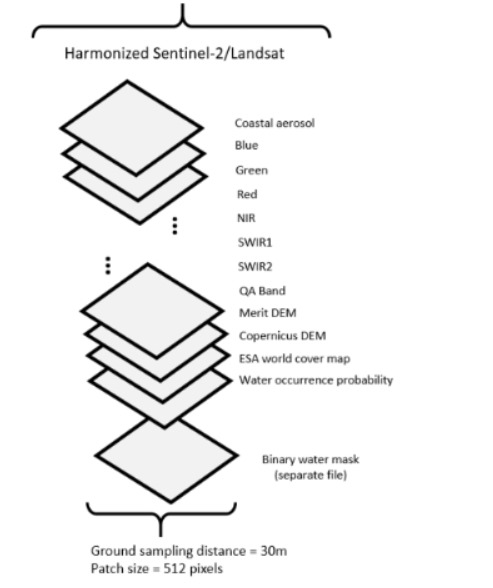
# Typical Band Combinations:
|**Band Type**|**Wavelength (nm)**|**Use Case**|
|-------------|-------------------|------------|
|`Blue`|~450|Water bodies, bathymetry|
|`Green`|~550|Vegetation, urban features|
|`Red`|~650|Land cover, built-up area|
|`NIR`|~850|Vegetation health, water contrast|
|`SWIR-1`|~1600|Moisture, snow/ice, burn area|
|`SWIR-2`|~2200|Soil, vegetation stress|
|`TIR`|~11,000+|Heat signatures, fire detection|

---

# 📂 Satellite Image Formats
- `.tif` / `.tiff`: Common GeoTIFF format — supports multi-band raster data
- `.npz` / `.npy`: Often used for deep learning after preprocessing
- `.jp2` / `.hdf5`: Other scientific image formats

---

#  Why Multiple Bands Matter in Deep Learning
Different surfaces (like water, vegetation, soil) reflect light differently at each wavelength. Deep learning models can exploit these differences to:
- 🌊 Detect water boundaries more clearly using `NIR` and `SWIR`
- 🌱 Distinguish healthy vs. stressed vegetation
- 🌇 Differentiate urban vs. rural land cover

---

# 🛠️ Preparing Satellite Images for Deep Learning
1. Normalize Each Band: Zero-mean and unit-variance (per band)
2. Resize if needed: Pad/crop to fixed shape (e.g. 128x128)
3. Augment Carefully: Don’t destroy spectral relationships

1. What makes water segmentation difficult?
  - Similar reflectance in NIR/SWIR with wet soil, shadow, urban areas
  - Water bodies vary by depth, pollution, clarity, sun angle
  1. Spectral Similarity
    - Water can appear similar to shadows, asphalt, and wet soil in visible bands.
    - Especially hard to detect in urban areas and mountainous regions.
  2. Dynamic Appearance
    - Water surfaces change due to wind, waves, depth, turbidity, and sun reflection.
    - Cloud cover, haze, and seasonal variation can distort pixel values.
  3. Label Ambiguity
    - Manual labeling of water is often error-prone.
    - Thin rivers, shorelines, and wetlands are hard to annotate.
---

2. Which bands are best for water detection?
  - NDWI (Normalized Difference Water Index) = (Green − NIR) / (Green + NIR)
  - MNDWI (Modified) = (Green − SWIR) / (Green + SWIR)
  - These use Band 3 (green), Band 5 (NIR), Band 6/7 (SWIR)

|Band|Wavelength (nm)|Role in Water Detection|
|----|---------------|-----------------------|
|`Green`|	~550	|Highlights vegetation/water boundary|
|`NIR`|	~850|	Water absorbs NIR → appears dark|
|`SWIR1`|	~1600	|Enhances contrast between water and soil|
|`SWIR2`|	~2200	|Useful for identifying moisture & ice|

**Popular Spectral Indices for Water**

These indices use mathematical operations on bands to highlight water features:

|Index	|Formula	|Use Case|
|-------|---------|--------|
|`NDWI`	|(`Green` − `NIR`) / (`Green` + `NIR`)	|Most common — works well in vegetation areas|
|`MNDWI`|	(`Green` − `SWIR`) / (`Green` + `SWIR`)	|Better contrast in urban areas|
|`AWEI`	|Multi-band combination (`SWIR`/`NIR`)	|Handles shadow, built-up areas, and haze|

---

3. What deep learning methods are used in literature?
 - U-Net, DeepLabV3+, and SegFormer dominate
 - Some use auxiliary tasks like NDWI estimation or unsupervised learning
 - Models often use patch-level training (128×128 or 256×256)

| Model               | Description                           | Notes                         |
| ------------------- | ------------------------------------- | ----------------------------- |
| **U-Net**           | Encoder-decoder with skip connections | Strong baseline               |
| **ResU-Net**        | Adds residuals to U-Net               | Improves training stability   |
| **Attention U-Net** | Focuses on key areas of image         | Better for cluttered scenes   |
| **DeepLabV3+**      | Atrous convolutions + encoder-decoder | Robust for complex boundaries |
| **SegFormer**       | Transformer-based segmentation        | Lightweight and accurate      |

---
🧪 Evaluation Metrics for Segmentation

| Metric|Description|
|-------|-----------|
|**IoU** (Intersection over Union)| Overlap between predicted & ground truth masks |
| **F1 Score**                      | Combines precision & recall                    |
| **Precision**                     | Measures false positives                       |
| **Recall**                        | Measures false negatives                       |
| **Pixel Accuracy**                | % of correctly classified pixels               |




## **0.1 Connect to google colab**

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import os
os.chdir('/content/drive/MyDrive/Cellula/02_Project 2')

## **0.2 Setup the device**

In [87]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## **0.3 Import Dependencies**

In [88]:
!pip install nvidia-pyindex
!pip install nvidia-tensorrt

In [89]:
pip install onnx onnxruntime tensorrt

In [90]:
!pip install torchviz

In [146]:
# ============================#
# 📦 Standard Library Imports
# ============================#
import os
import glob
import random
import time

# ============================#
# 🧮 Numerical and Data Tools
# ============================#
import numpy as np
import pandas as pd

# ============================#
# 📊 Visualization Libraries
# ============================#
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from rich.console import Console
from rich.table import Table
from rich import print as rprint
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from IPython.display import Image, display

# ============================#
# 🔍 Deep Learning & Torch
# ============================#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from torchviz import make_dot

# ============================#
# 🧠 ONNX / TensorRT Inference
# ============================#
import onnx
import onnxruntime
import tensorrt  # Consider renaming to tensorrt as trt for consistency

# ============================#
# 🗺️ Raster Data Handling
# ============================#
try:
    import rasterio
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "rasterio"])
    import rasterio

# ============================#
# ⚙️ Console for Rich Output
# ============================#
console = Console()

In [92]:
# to get packages initially installed in colab or in other word, the colab environment
!pip3 freeze > requirements.txt

## 📁 **0.4 Setup All Project Paths**

In [93]:
def prepare_folders(base_dir="project"):
    """
    Create required directories for data, results, models, stats, etc.
    """
    folders = [
        "outputs/visuals", "outputs/checkpoints",
        "outputs/models", "outputs/npz", "outputs/stats"
    ]

    for folder in folders:
        full_path = os.path.join(base_dir, folder)
        os.makedirs(full_path, exist_ok=True)
        console.log(f"[green]✔ Created folder:[/green] {full_path}")

    rprint("[bold cyan]✅ All folders are ready![/bold cyan]")

prepare_folders()

[18:18:52] ✔ Created folder: project/outputs/visuals                               ]8;id=261068;file:///tmp/ipython-input-93-669953086.py\ipython-input-93-669953086.py]8;;\:]8;id=371782;file:///tmp/ipython-input-93-669953086.py#13\13]8;;\

           ✔ Created folder: project/outputs/checkpoints                           ]8;id=940441;file:///tmp/ipython-input-93-669953086.py\ipython-input-93-669953086.py]8;;\:]8;id=295554;file:///tmp/ipython-input-93-669953086.py#13\13]8;;\

           ✔ Created folder: project/outputs/models                                ]8;id=667402;file:///tmp/ipython-input-93-669953086.py\ipython-input-93-669953086.py]8;;\:]8;id=560084;file:///tmp/ipython-input-93-669953086.py#13\13]8;;\

           ✔ Created folder: project/outputs/npz                                   ]8;id=389586;file:///tmp/ipython-input-93-669953086.py\ipython-input-93-669953086.py]8;;\:]8;id=479309;file:///tmp/ipython-input-93-669953086.py#13\13]8;;\

           ✔ Created folder: project/outputs/stats                                 ]8;id=71360;file:///tmp/ipython-input-93-669953086.py\ipython-input-93-669953086.py]8;;\:]8;id=330112;file:///tmp/ipython-input-93-669953086.py#13\13]8;;\

✅ All folders are ready!

## **📦 0.5 Define Data Paths**

In [94]:
# Root project path
ROOT = "project"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"
RESULTS_DIR = os.path.join(ROOT, "outputs")
VISUAL_DIR = os.path.join(RESULTS_DIR, "visuals")
NPZ_DIR = os.path.join(RESULTS_DIR, "npz")

# List image and label files
image_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.tif")))
label_paths = sorted(glob.glob(os.path.join(LABEL_DIR, "*.png")))

console.rule("[bold yellow] Dataset Summary[/bold yellow]")
table = Table(title="Water Segmentation Dataset")

table.add_column("Field", style="bold cyan")
table.add_column("Value", style="white")

table.add_row("Number of Images", str(len(image_paths)))
table.add_row("Number of Masks", str(len(label_paths)))
console.print(table)

────────────────────────────────────────────────  Dataset Summary ─────────────────────────────────────────────────

 Water Segmentation Dataset 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Field            ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Number of Images │ 306   │
│ Number of Masks  │ 456   │
└──────────────────┴───────┘

**Mismatched Image & Mask Counts**

- 306 `.tif` images
- 456 `.png` masks

That’s a mismatch, and we should only keep pairs where both image and mask exist (i.e., matching filenames like 0.tif & 0.png).

In [95]:
def get_matched_image_label_paths(img_dir, label_dir):
    image_files = sorted(glob.glob(os.path.join(img_dir, "*.tif")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "*.png")))

    matched_images, matched_labels = [], []
    for img_path in image_files:
        fname = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(label_dir, f"{fname}.png")
        if os.path.exists(lbl_path):
            matched_images.append(img_path)
            matched_labels.append(lbl_path)

    return matched_images, matched_labels

In [96]:
image_paths, label_paths = get_matched_image_label_paths(IMG_DIR, LABEL_DIR)

In [101]:
def get_image_mask_shapes(image_path, label_path):
    with rasterio.open(image_path) as src:
        img_shape = src.read().shape  # (bands, H, W)

    mask = Image.open(label_path) # Fix: Should be PIL.Image.open() since PIL is imported as Image
    mask_shape = np.array(mask).shape  # (H, W)

    return img_shape, mask_shape

In [147]:
img_shape, mask_shape = get_image_mask_shapes(image_paths[0], label_paths[0])

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



AttributeError: type object 'Image' has no attribute 'open'

In [103]:
table.add_row("Number of Images", str(len(image_paths)))
table.add_row("Number of Masks", str(len(label_paths)))
table.add_row("Image Shape", f"{img_shape} (multispectral .tif)")
table.add_row("Mask Shape", f"{mask_shape} (binary .png)")
table.add_row("Bands per Image", str(img_shape[0]))

In [104]:
console.print(table)

                Water Segmentation Dataset                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field            ┃ Value                               ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Number of Images │ 306                                 │
│ Number of Masks  │ 456                                 │
│ Number of Images │ 306                                 │
│ Number of Masks  │ 306                                 │
│ Image Shape      │ (12, 128, 128) (multispectral .tif) │
│ Mask Shape       │ (128, 128) (binary .png)            │
│ Bands per Image  │ 12                                  │
└──────────────────┴─────────────────────────────────────┘

In [105]:
# Setup
LABEL_DIR = "data/labels"  # path to raw masks
SAMPLE_SIZE = 10           # number of masks to inspect

console = Console()
label_files = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith(".png")])
sample_masks = random.sample(label_files, min(SAMPLE_SIZE, len(label_files)))

def analyze_mask(mask_path):
    full_path = os.path.join(LABEL_DIR, mask_path)
    mask = Image.open(full_path).convert("L")  # don't resize yet
    mask_np = np.array(mask)

    unique_vals = np.unique(mask_np)
    min_val = mask_np.min()
    max_val = mask_np.max()

    # Display stats
    table = Table(title=f"[cyan]{mask_path}[/cyan] - Raw Mask Stats")
    table.add_column("Min", justify="center")
    table.add_column("Max", justify="center")
    table.add_column("Unique Values", justify="center")
    table.add_row(str(min_val), str(max_val), str(unique_vals.tolist()))
    console.print(table)

    # Show mask and histogram
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(mask_np, cmap="gray")
    axs[0].set_title("Raw Mask Image")
    axs[0].axis("off")

    axs[1].hist(mask_np.ravel(), bins=256, color="purple", alpha=0.7)
    axs[1].set_title("Pixel Intensity Histogram")
    axs[1].set_xlabel("Pixel Value")
    axs[1].set_ylabel("Count")

    plt.suptitle(f"📄 {mask_path}")
    plt.tight_layout()
    plt.show()

# Run check
console.rule("[bold yellow]🔍 Checking Sample Raw Masks Before Preprocessing[/bold yellow]")
for mask_file in sample_masks:
    analyze_mask(mask_file)

──────────────────────────────── 🔍 Checking Sample Raw Masks Before Preprocessing ────────────────────────────────

AttributeError: type object 'Image' has no attribute 'open'

In [106]:
def summarize_file_counts(image_dir, label_dir):
    all_images = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
    all_labels = sorted(glob.glob(os.path.join(label_dir, "*.png")))

    image_names = {os.path.splitext(os.path.basename(p))[0] for p in all_images}
    label_names = {os.path.splitext(os.path.basename(p))[0] for p in all_labels}

    missing_labels = image_names - label_names
    missing_images = label_names - image_names
    matched = image_names & label_names

    return {
        "images": all_images,
        "labels": all_labels,
        "matched_ids": sorted(matched),
        "missing_labels": sorted(missing_labels),
        "missing_images": sorted(missing_images),
    }

In [107]:
def print_mismatch_summary(summary_dict):
    table = Table(title="🧠 Dataset Consistency Check", show_lines=True)
    table.add_column("Metric", style="cyan", justify="left")
    table.add_column("Value", style="white", justify="right")

    table.add_row("📸 Total Images Found", str(len(summary_dict["images"])))
    table.add_row("🖼 Total Masks Found", str(len(summary_dict["labels"])))
    table.add_row("✅ Matched Pairs", str(len(summary_dict["matched_ids"])))
    table.add_row("❌ Images Missing Labels", str(len(summary_dict["missing_labels"])))
    table.add_row("❌ Labels Missing Images", str(len(summary_dict["missing_images"])))

    console.print(table)

In [108]:
def get_clean_image_label_paths(image_dir, label_dir, matched_ids):
    images = [os.path.join(image_dir, f"{img_id}.tif") for img_id in matched_ids]
    labels = [os.path.join(label_dir, f"{img_id}.png") for img_id in matched_ids]
    return images, labels

In [109]:
dataset_summary = summarize_file_counts(IMG_DIR, LABEL_DIR)
print_mismatch_summary(dataset_summary)

    🧠 Dataset Consistency Check    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                   ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ 📸 Total Images Found    │   306 │
├──────────────────────────┼───────┤
│ 🖼 Total Masks Found      │   456 │
├──────────────────────────┼───────┤
│ ✅ Matched Pairs         │   306 │
├──────────────────────────┼───────┤
│ ❌ Images Missing Labels │     0 │
├──────────────────────────┼───────┤
│ ❌ Labels Missing Images │   150 │
└──────────────────────────┴───────┘

In [110]:
dataset_summary = summarize_file_counts(IMG_DIR, LABEL_DIR)
image_paths, label_paths = get_clean_image_label_paths(IMG_DIR, LABEL_DIR, dataset_summary["matched_ids"])
rprint(f"[bold green]✅ Cleaned pairs ready for training:[/bold green] {len(image_paths)} samples")

✅ Cleaned pairs ready for training: 306 samples

# 1. **1. Spectral Band Explorer**

In [111]:
BAND_LABELS = {
    0: "🌊 Coastal Blue",
    1: "🔵 Blue",
    2: "🟢 Green (NDWI)",
    3: "🔴 Red",
    4: "🌿 NIR",
    5: "🔥 SWIR-1",
    6: "❄️ SWIR-2",
    7: "🌡️ Thermal IR",
    8: "🛰 Panchromatic",
    9: "☁ Cloud Mask",
    10: "⚠️ QA Band",
    11: "📏 DEM / Extra"
}

In [112]:
def plot_all_bands_with_labels(image_path):
    """
    Plot all 12 bands with custom labels and emojis using Plotly.
    """
    with rasterio.open(image_path) as src:
        img = src.read()  # shape: (bands, H, W)

    bands = img.shape[0]
    fig = sp.make_subplots(rows=3, cols=4, subplot_titles=[BAND_LABELS[i] for i in range(bands)])

    for i in range(bands):
        fig.add_trace(
            go.Heatmap(
                z=img[i],
                colorscale="gray",
                showscale=False
            ),
            row=i // 4 + 1,
            col=i % 4 + 1
        )

    fig.update_layout(
        title=dict(
            text="🔍 <b>Spectral Band Explorer</b>",
            x=0.5,
            font=dict(size=22, color="white")
        ),
        template="plotly_dark",
        height=750,
        width=1000,
        margin=dict(t=80),
        font=dict(family="Arial", color="white")
    )

    fig.show()

In [113]:
rprint("[bold green]📸 Visualizing Sample with Band Labels[/bold green]")
plot_all_bands_with_labels(image_paths[0])

📸 Visualizing Sample with Band Labels

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.



# **2. Data Preprocessing & Normalization Engine**
- Loads `.tif` image and `.png` mask
- Normalizes each band (zero-mean, unit-variance)
-  Ensures shapes are consistent: (12, 128, 128) for image, (1, 128, 128) for mask


Preprocessing: Image and Mask

This function `preprocess_image_mask()` is responsible for loading and preparing the raw satellite data for training. It performs the following steps:

1. Satellite Image (Multispectral)
  - Loads the input image using `rasterio`, which typically contains **12 spectral bands**.
  - Applies **per-band normalization** (zero-mean, unit-variance) to standardize input features across samples.
  - Final image shape: **(12, height, width)**

2. Segmentation Mask (Water / Non-water)
  - Loads the mask image and resizes it to **128×128 pixels**.
  - Converts to grayscale (if not already).
  - Ensures it's binary: values are **0.0 or 1.0**, using a threshold if needed.
  - Adds a channel dimension → final shape: **(1, 128, 128)**

3. Output
  - Returns the normalized image and binarized mask as NumPy arrays.


In [114]:
def preprocess_image_mask(image_path, mask_path):
    """
    Load and normalize a satellite image along with its corresponding binary mask.

    Parameters:
    - image_path: str, path to the satellite image (GeoTIFF, 12 bands).
    - mask_path: str, path to the segmentation mask image.

    Returns:
    - image: np.ndarray, normalized image array with shape (12, H, W)
    - mask: np.ndarray, binary mask with shape (1, 128, 128)
    """
    # --- Load multispectral satellite image (usually 12 spectral bands) ---
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # shape: (12, H, W), dtype: float32

    # --- Normalize image per band: zero mean, unit variance ---
    # This ensures that each channel (band) has standardized values.
    image = (image - image.mean(axis=(1, 2), keepdims=True)) / \
            (image.std(axis=(1, 2), keepdims=True) + 1e-7)

    # --- Load and process segmentation mask ---
    # Convert to grayscale, resize to 128x128 pixels
    mask = Image.open(mask_path).convert("L").resize((128, 128), Image.NEAREST) # Fix: Should be PIL.Image.open()
    mask = np.array(mask)

    # --- Ensure mask is binary (0 or 1) ---
    # If mask is in [0, 255] → threshold at 127 to binarize
    if mask.max() > 1:
        mask = (mask > 127).astype(np.float32)
    else:
        mask = mask.astype(np.float32)

    # --- Add channel dimension to match model input format ---
    # Final shape: (1, 128, 128)
    mask = mask[None, :, :]

    # --- Debug output: Print unique values in the mask ---
    unique_vals = np.unique(mask)
    rprint(f"[bold blue]🧪 {os.path.basename(mask_path)} → Unique mask values: {unique_vals}[/bold blue]")

    return image, mask

In [115]:
def print_band_statistics(image):
    table = Table(title="📊 Normalized Band Stats", show_lines=True)
    table.add_column("Band", style="cyan", justify="center")
    table.add_column("Mean", justify="center")
    table.add_column("Std Dev", justify="center")

    for i in range(image.shape[0]):
        band = image[i]
        table.add_row(f"{i+1}", f"{band.mean():.4f}", f"{band.std():.4f}")

    console.print(table)

In [116]:
def visualize_image_and_mask(image, mask, title="Sample"):
    """
    Plot the first band of the image + mask side-by-side.
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(image[0], cmap="gray")
    axs[0].set_title("Band 1")
    axs[1].imshow(mask.squeeze(), cmap="gray")
    axs[1].set_title("Mask")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [117]:
print("✅ Matched samples:", len(image_paths))
img, msk = preprocess_image_mask(image_paths[0], label_paths[0])
visualize_image_and_mask(img, msk, title=os.path.basename(image_paths[0]))

✅ Matched samples: 306


AttributeError: type object 'Image' has no attribute 'open'

In [118]:
def visualize_image_and_mask(image, mask, title="Sample"):
    """
    Plot the first band of the image + mask side-by-side.
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(image[0], cmap="gray")
    axs[0].set_title("Band 1")
    axs[1].imshow(mask.squeeze(), cmap="gray")
    axs[1].set_title("Mask")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [119]:
print("✅ Matched samples:", len(image_paths))
img, msk = preprocess_image_mask(image_paths[0], label_paths[0])
visualize_image_and_mask(img, msk, title=os.path.basename(image_paths[0]))

✅ Matched samples: 306


AttributeError: type object 'Image' has no attribute 'open'

In [120]:
# Check all masks once
empty_masks = 0
for img_path, lbl_path in zip(image_paths, label_paths):
    _, mask = preprocess_image_mask(img_path, lbl_path)
    if np.all(mask == 0):
        empty_masks += 1

rprint(f"[bold red]❗ Total empty masks (all 0): {empty_masks} / {len(label_paths)}[/bold red]")

AttributeError: type object 'Image' has no attribute 'open'

In [121]:
def save_to_npz(images, masks, out_path="outputs/npz/dataset.npz"):
    np.savez_compressed(out_path, images=images, masks=masks)
    rprint(f"[bold green]✅ Saved dataset to:[/bold green] {out_path}")

In [122]:
def preprocess_all_dataset(image_paths, label_paths, save_path=os.path.join(NPZ_DIR, "dataset.npz")):
    """
    Preprocess all images and masks and save as .npz file.
    """
    all_images, all_masks = [], []

    console.rule("[bold blue]🧪 Starting Full Dataset Preprocessing[/bold blue]")

    for idx, (img_path, msk_path) in enumerate(zip(image_paths, label_paths)):
        img, msk = preprocess_image_mask(img_path, msk_path)
        all_images.append(img)
        all_masks.append(msk)

        if idx < 3:  # Just show stats for first 3
            rprint(f"[bold cyan]🔎 Sample {idx+1} - {os.path.basename(img_path)}[/bold cyan]")
            print_band_statistics(img)

    all_images = np.stack(all_images)  # shape: (N, 12, 128, 128)
    all_masks = np.stack(all_masks)    # shape: (N, 1, 128, 128)

    save_to_npz(all_images, all_masks, save_path)


In [123]:
dataset_summary = summarize_file_counts(IMG_DIR, LABEL_DIR)
image_paths, label_paths = get_clean_image_label_paths(IMG_DIR, LABEL_DIR, dataset_summary["matched_ids"])

# Preprocess & Save
preprocess_all_dataset(image_paths, label_paths)

───────────────────────────────────── 🧪 Starting Full Dataset Preprocessing ──────────────────────────────────────

AttributeError: type object 'Image' has no attribute 'open'

# **3. Dataset Loader & Split Engine**

## **3.1 Step 1: Load and Split .npz Data**

In [124]:
def load_npz_dataset(npz_path):
    data = np.load(npz_path)
    images = data["images"]    # shape: (N, 12, 128, 128)
    masks = data["masks"]      # shape: (N, 1, 128, 128)
    return images, masks

## **3.2 Step 2: Build PyTorch Dataset Class**

This custom PyTorch dataset is designed to handle satellite images and their corresponding water segmentation masks. It prepares data in a format suitable for training deep learning models.

- Inputs
  - `images`: A list or NumPy array of multispectral satellite images, each with 12 channels (bands).
  - `masks`: A list or array of binary water masks corresponding to each image.
- Purpose
 - Converts each image and mask to PyTorch tensors.
 - Ensures compatibility with DataLoader for batching and shuffling.
 - Enables easy integration into PyTorch training loops.
- Output
  - A tuple of (`image`, `mask`) for each sample, both as float32 tensors.

In [125]:
class WaterSegmentationDataset(Dataset):
    """
    Custom PyTorch Dataset for loading satellite images and their corresponding binary water masks.

    Args:
        images (List or np.ndarray): A list or array of normalized multispectral images.
                                     Each image should have shape (12, H, W), where 12 is the number of spectral bands.
        masks (List or np.ndarray): A list or array of binary masks corresponding to each image.
                                    Each mask should have shape (1, H, W), where 1 indicates a single binary channel.

    Returns:
        image (torch.Tensor): A float32 tensor of the image, shape (12, H, W).
        mask (torch.Tensor): A float32 tensor of the mask, shape (1, H, W).
    """

    def __init__(self, images, masks):
        # Store references to the images and masks
        self.images = images
        self.masks = masks

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        """
        Load a single sample from the dataset at index `idx`.

        Returns:
            (image, mask): A tuple of tensors ready for training.
        """
        # Convert the image and mask at index `idx` to PyTorch tensors
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32)
        return image, mask


## **3.3 Step 3: Split Dataset + Build Loaders**

In [126]:
def prepare_dataloaders(npz_path, val_ratio=0.5, test_ratio=0.1, batch_size=16, seed=42):
    images, masks = load_npz_dataset(npz_path)
    dataset = WaterSegmentationDataset(images, masks)

    total = len(dataset)
    val_size = int(val_ratio * total)
    test_size = int(test_ratio * total)
    train_size = total - val_size - test_size

    torch.manual_seed(seed)
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, len(train_ds), len(val_ds), len(test_ds)

In [127]:
def print_split_summary(train_len, val_len, test_len):
    total = train_len + val_len + test_len
    table = Table(title="📊 Dataset Split Summary", show_lines=True)
    table.add_column("Set", style="bold cyan")
    table.add_column("Samples", justify="center")
    table.add_column("Percentage", justify="center")

    table.add_row("🧪 Train", str(train_len), f"{train_len/total*100:.1f}%")
    table.add_row("🔍 Validation", str(val_len), f"{val_len/total*100:.1f}%")
    table.add_row("🧫 Test", str(test_len), f"{test_len/total*100:.1f}%")
    table.add_row("📦 Total", str(total), "100%")
    console.print(table)

In [128]:
rprint("[bold magenta]📦 Loading Preprocessed Data & Preparing Loaders[/bold magenta]")
npz_path = os.path.join(NPZ_DIR, "dataset.npz")
train_loader, val_loader, test_loader, N_train, N_val, N_test = prepare_dataloaders(npz_path)

print_split_summary(N_train, N_val, N_test)

📦 Loading Preprocessed Data & Preparing Loaders

        📊 Dataset Split Summary        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Set           ┃ Samples ┃ Percentage ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━┩
│ 🧪 Train      │   123   │   40.2%    │
├───────────────┼─────────┼────────────┤
│ 🔍 Validation │   153   │   50.0%    │
├───────────────┼─────────┼────────────┤
│ 🧫 Test       │   30    │    9.8%    │
├───────────────┼─────────┼────────────┤
│ 📦 Total      │   306   │    100%    │
└───────────────┴─────────┴────────────┘

# **4. Automated Model Search with Optuna + Tracking**

## **4.1 Define multiple model architectures**

### 4.1.1 UNet

The U-Net model is a powerful convolutional architecture designed for pixel-wise segmentation. It follows an encoder–decoder structure with skip connections.
  - Encoder: Extracts hierarchical features using convolution + pooling.
  - Bottleneck: The deepest part of the network that captures abstract context.
  - Decoder: Upsamples features and fuses them with encoder features (via skip connections) to reconstruct pixel-level output.
  - Final Output: A 1-channel probability map predicting the presence of water per pixel.

In [129]:
class DoubleConv(nn.Module):
    """Applies two convolutional layers each followed by BatchNorm and ReLU activation."""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Conv layer
            nn.BatchNorm2d(out_channels),                                     # Normalization
            nn.ReLU(inplace=True),                                            # Activation

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # 2nd Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [130]:
class UNet(nn.Module):
    """
    Standard U-Net architecture for semantic segmentation.

    Structure:
    - Encoder (Downsampling): 4 blocks of DoubleConv + MaxPooling.
    - Bottleneck: Deepest layer.
    - Decoder (Upsampling): Transposed conv + skip connections + DoubleConv.
    - Final layer: 1x1 conv followed by Sigmoid activation to get pixel-wise probabilities.
    """

    def __init__(self, in_channels=12, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features

        # Encoder Path
        self.encoder1 = DoubleConv(in_channels, features)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features, features * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(features * 8, features * 16)

        # Decoder Path
        self.up4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features * 16, features * 8)

        self.up3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features * 8, features * 4)

        self.up2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features * 4, features * 2)

        self.up1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features * 2, features)

        # Final output layer → 1-channel probability map
        self.out = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with skip connections
        d4 = torch.cat([self.up4(b), e4], dim=1)
        d4 = self.decoder4(d4)

        d3 = torch.cat([self.up3(d4), e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = torch.cat([self.up2(d3), e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = torch.cat([self.up1(d2), e1], dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.out(d1))  # Output pixel-wise probability

### 4.2.2 RescueUNet Architecture

The `RescueUNet` model is a U-Net inspired encoder-decoder architecture enhanced with **Residual Blocks**.  
It is designed for binary segmentation tasks such as water segmentation in satellite images.

- ResidualBlock
  - Each residual block:
    - Contains two 3x3 convolutions with batch normalization and ReLU activation
    - Includes a shortcut connection (1x1 convolution) that bypasses the block
    - Helps prevent vanishing gradients in deep networks
- Encoder Path (Contracting Path)
  - Repeated application of residual blocks followed by max pooling
  - Downsamples spatial resolution while increasing feature depth
- Bottleneck
  - The deepest part of the network with the most abstract features
- Decoder Path (Expanding Path)
  - Upsampling using transposed convolutions
  - Skip connections concatenate encoder features with decoder features
  - Residual blocks refine combined features
- Final Output
  - A 1x1 convolution projects the final decoder output to the desired number of classes
  - Uses a sigmoid activation to produce a **binary mask** (values between 0 and 1)

In [131]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        A residual block that helps avoid vanishing gradients and stabilizes deep training.
        It includes:
        - 2 convolutional layers with batch normalization and ReLU
        - A shortcut connection to add the original input to the output
        """
        super().__init__()

        # Main path of the residual block (Conv-BN-ReLU → Conv-BN)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # Shortcut connection to match dimensions (1x1 conv)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Output = activation(conv(x) + shortcut(x))
        return F.relu(self.conv(x) + self.shortcut(x))

class RescueUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, features=32):
        """
        A U-Net inspired architecture with residual blocks (RescueUNet).
        Consists of:
        - Encoder: Downsampling with residual blocks and max pooling
        - Bottleneck: Deepest layer
        - Decoder: Upsampling with ConvTranspose + skip connections + residual blocks
        """
        super().__init__()
        self.model_name = "RescueUNet"

        # -------------------- Encoder Path --------------------
        self.enc1 = ResidualBlock(in_channels, features)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResidualBlock(features, features * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ResidualBlock(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ResidualBlock(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2)

        # -------------------- Bottleneck --------------------
        self.bottleneck = ResidualBlock(features * 8, features * 16)

        # -------------------- Decoder Path --------------------
        self.up4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = ResidualBlock(features * 16, features * 8)

        self.up3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(features * 8, features * 4)

        self.up2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(features * 4, features * 2)

        self.up1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(features * 2, features)

        # Final 1x1 convolution to get output segmentation mask
        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # -------- Encoder --------
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # -------- Bottleneck --------
        b = self.bottleneck(self.pool4(e4))

        # -------- Decoder --------
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))  # Skip connection
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # -------- Output Layer --------
        return torch.sigmoid(self.final(d1))  # Output: Probability mask (0 to 1)


### 4.2.3 LiteUNet Model

- Overview:
The `LiteUNet` is a simplified version of the traditional U-Net architecture, optimized for satellite water segmentation with reduced computational cost. It's particularly effective for binary segmentation tasks and works well with 12-band multispectral imagery.


- Key Components:
  - **Encoder:** Two convolutional blocks followed by max pooling, gradually reducing spatial resolution while increasing feature depth.
  - **Bottleneck:** The deepest part of the network that captures the most abstract features.
  - **Decoder:** Upsampling using transpose convolutions followed by convolutional blocks. Skip connections merge encoder features to help restore spatial details.
  - **Output Layer:** A `1x1` convolution followed by `sigmoid` to generate pixel-wise binary predictions.

- Parameters:
  - `in_channels`: Number of input channels (default: 12 for multispectral images)
  - `out_channels`: Number of output channels (default: 1 for binary mask)
  - `base_channels`: Controls the width of the network (default: 16)

- Output:
  - Returns a tensor of shape `(B, 1, H, W)` with pixel values ∈ [0, 1], where values closer to 1 indicate water regions.


In [132]:
class LiteConvBlock(nn.Module):
    """
    A basic convolutional block used in both the encoder and decoder paths of the LiteUNet.
    Each block consists of:
        - Conv2D → ReLU → Conv2D → ReLU
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Conv layer 1
            nn.ReLU(inplace=True),                                            # Activation
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), # Conv layer 2
            nn.ReLU(inplace=True)                                             # Activation
        )

    def forward(self, x):
        return self.block(x)

class LiteUNet(nn.Module):
    """
    LiteUNet — A lightweight U-Net model designed for fast water segmentation from satellite imagery.

    Architecture Summary:
        - Encoder: Two downsampling convolutional blocks with MaxPooling
        - Bottleneck: A deeper conv block to learn compressed representations
        - Decoder: Two upsampling paths using ConvTranspose2D and skip connections
        - Output: 1-channel segmentation map (using sigmoid activation)
    """

    def __init__(self, in_channels=12, out_channels=1, base_channels=16):
        super().__init__()
        self.model_name = "LiteUNet"

        # ---- Encoder Path ----
        self.enc1 = LiteConvBlock(in_channels, base_channels)          # First conv block: 12 → 16
        self.pool1 = nn.MaxPool2d(kernel_size=2)                       # Downsample: H/2, W/2

        self.enc2 = LiteConvBlock(base_channels, base_channels * 2)   # Second block: 16 → 32
        self.pool2 = nn.MaxPool2d(kernel_size=2)                       # Downsample: H/4, W/4

        # ---- Bottleneck ----
        self.bottleneck = LiteConvBlock(base_channels * 2, base_channels * 4)  # 32 → 64

        # ---- Decoder Path ----
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = LiteConvBlock(base_channels * 4, base_channels * 2)  # concat(32+32) → 32

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = LiteConvBlock(base_channels * 2, base_channels)      # concat(16+16) → 16

        # ---- Final Output Layer ----
        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)  # 16 → 1

    def forward(self, x):
        # ---- Encoder ----
        e1 = self.enc1(x)                     # Output shape: (B, 16, H, W)
        e2 = self.enc2(self.pool1(e1))       # (B, 32, H/2, W/2)

        # ---- Bottleneck ----
        b = self.bottleneck(self.pool2(e2))  # (B, 64, H/4, W/4)

        # ---- Decoder ----
        d2 = self.up2(b)                     # Upsample: (B, 32, H/2, W/2)
        d2 = torch.cat([d2, e2], dim=1)      # Skip connection
        d2 = self.dec2(d2)                   # (B, 32, H/2, W/2)

        d1 = self.up1(d2)                    # Upsample: (B, 16, H, W)
        d1 = torch.cat([d1, e1], dim=1)      # Skip connection
        d1 = self.dec1(d1)                   # (B, 16, H, W)

        # ---- Final Output ----
        out = torch.sigmoid(self.final(d1))  # Output mask: (B, 1, H, W) with values [0, 1]
        return out

In [133]:
def analyze_and_save_model(model, name="model", out_dir="project/outputs/models"):
    print(f"\n🔍 Analyzing model: {name}")
    start_time = time.time()

    model.to(device)
    model.eval()

    # Count total and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"📦 Total parameters: {total_params:,}")
    print(f"🎯 Trainable parameters: {trainable_params:,}")

    # Save model weights
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, f"{name}.pt")
    torch.save(model.state_dict(), save_path)

    elapsed = time.time() - start_time
    print(f"✅ [Saved] {name} in {elapsed:.2f} seconds ➜ {save_path}")

In [134]:
pure_unet = UNet(in_channels=12, out_channels=1)
rescue_unet = RescueUNet(in_channels=12, out_channels=1)
Lite_Unet = LiteUNet(in_channels=12, out_channels=1)

analyze_and_save_model(pure_unet, name="PureUNet12")
analyze_and_save_model(rescue_unet, name="RescueUNet")
analyze_and_save_model(Lite_Unet, name="LiteUNet")


🔍 Analyzing model: PureUNet12
📦 Total parameters: 7,768,577
🎯 Trainable parameters: 7,768,577
✅ [Saved] PureUNet12 in 0.12 seconds ➜ project/outputs/models/PureUNet12.pt

🔍 Analyzing model: RescueUNet
📦 Total parameters: 8,118,593
🎯 Trainable parameters: 8,118,593
✅ [Saved] RescueUNet in 0.18 seconds ➜ project/outputs/models/RescueUNet.pt

🔍 Analyzing model: LiteUNet
📦 Total parameters: 118,337
🎯 Trainable parameters: 118,337
✅ [Saved] LiteUNet in 0.05 seconds ➜ project/outputs/models/LiteUNet.pt


In [135]:
x = torch.randn(4, 12, 128, 128)
out1 = pure_unet(x)
print(out1.shape)
out2 = rescue_unet(x)
print(out2.shape)
out3 = Lite_Unet(x)
print(out3.shape)

torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])


In [136]:
def visualize_model_architecture(model, input_shape=(1, 12, 128, 128), model_name="model", show=True, save=True):
    """
    Visualizes the architecture of a PyTorch model using torchviz.

    Args:
        model (torch.nn.Module): The PyTorch model to visualize.
        input_shape (tuple): Shape of the dummy input tensor, default is (1, 12, 128, 128).
        model_name (str): Name to save the diagram as (without extension).
        show (bool): Whether to display the image inline (for notebooks).
        save (bool): Whether to save the image as a .png file.

    Returns:
        None
    """
    # Set model to evaluation mode
    model.eval()

    # Create dummy input
    dummy_input = torch.randn(input_shape)

    # Forward pass to get output
    output = model(dummy_input)

    # Generate diagram
    dot = make_dot(output, params=dict(model.named_parameters()))

    # Save and optionally display
    if save:
        filename = f"{model_name}_architecture"
        dot.render(filename, format="png")
        print(f"[✓] Saved: {filename}.png")

    if show:
        display(Image(f"{model_name}_architecture.png"))

In [137]:
# Visualize pure_unet
visualize_model_architecture(pure_unet, model_name="pure_unet")

# Visualize rescue_unet
visualize_model_architecture(rescue_unet, model_name="rescue_unet")

# Visualize Lite_Unet
visualize_model_architecture(Lite_Unet, model_name="lite_unet")

Output hidden; open in https://colab.research.google.com to view.

## **4.2 	Define objective function for Optuna**

In [138]:
try:
  import optuna
except:
  !pip install optuna
  import optuna
from tqdm import tqdm
import torch.nn.functional as F

In [139]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    loss = 1 - ((2. * intersection + smooth) / (union + smooth))
    return loss.mean()

In [140]:
def combo_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dsc = dice_loss(pred_sigmoid, target)
    return 0.5 * bce + 0.5 * dsc

In [141]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

In [142]:
def evaluate_iou(model, loader, device):
    model.eval()
    ious = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            out = torch.sigmoid(out)  # Since model outputs raw logits
            pred = (out > 0.5).float()

            # Debug info
            print("🔍 Prediction stats:", pred.min().item(), pred.max().item(), pred.mean().item())
            print("📌 Target stats:", y.min().item(), y.max().item(), y.mean().item())

            inter = (pred * y).sum(dim=(2,3))
            union = (pred + y - pred * y).sum(dim=(2,3))
            iou = (inter / (union + 1e-7)).mean().item()
            ious.append(iou)
    return sum(ious) / len(ious)

In [143]:
def get_model_by_name(name):
    if name == "PureUNet12":
        return UNet(in_channels=12, out_channels=1)
    elif name == "RescueUNet":
        return RescueUNet(in_channels=12, out_channels=1)
    elif name == "LiteUNet":
        return LiteUNet(in_channels=12, out_channels=1)


In [144]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = trial.suggest_categorical("model", ["PureUNet12", "RescueUNet", "LiteUNet"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])

    model = get_model_by_name(model_name).to(device)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    best_iou = 0.0
    for epoch in range(3):
        print(f"\n📚 Trial {trial.number} | Epoch {epoch+1}")
        loss = train_one_epoch(model, train_loader, optimizer, combo_loss, device)
        iou = evaluate_iou(model, val_loader, device)
        print(f"📉 Loss: {loss:.4f} | 📈 IoU: {iou:.4f}")
        trial.report(iou, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        best_iou = max(best_iou, iou)

    # Save model
    os.makedirs("project/outputs/models", exist_ok=True)
    torch.save(model.state_dict(), f"project/outputs/models/{model_name}_trial{trial.number}.pt")
    return best_iou

In [145]:
model = get_model_by_name("PureUNet12").to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    print(f"\nManual Run | Epoch {epoch+1}")
    loss = train_one_epoch(model, train_loader, optimizer, combo_loss, device)
    iou = evaluate_iou(model, val_loader, device)
    print(f"📉 Loss: {loss:.4f} | 📈 IoU: {iou:.4f}")



Manual Run | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7432 | 📈 IoU: 0.2539

Manual Run | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stat

In [148]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print(study.best_trial.params)

[I 2025-07-17 18:26:01,378] A new study created in memory with name: no-name-4d0addc6-ba34-4065-85c8-c56ed6a4e4c1
/tmp/ipython-input-144-3550752042.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.




📚 Trial 0 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7255 | 📈 IoU: 0.2539

📚 Trial 0 | Epoch 2
🔍 Prediction stats: 0.0 1.0 0.6612663269042969
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 0.0 1.0 0.6637191772460938
📌 Target stats: 0.0 1.0 0.1900291

[I 2025-07-17 18:30:49,627] Trial 0 finished with value: 0.2551975205540657 and parameters: {'model': 'RescueUNet', 'lr': 0.0020137038220424384, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2551975205540657.



📚 Trial 1 | Epoch 1
🔍 Prediction stats: 0.0 1.0 0.9999198913574219
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 0.0 1.0 0.9999580383300781
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 0.0 1.0 0.9999923706054688
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7084 | 📈 IoU: 0.2539

📚 Trial 1 | Epoch 2
🔍 Prediction stats: 0.0 1.0 0.9996795654296875
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 0.0 1.0 0.99986

[I 2025-07-17 18:35:30,432] Trial 1 finished with value: 0.2563173621892929 and parameters: {'model': 'RescueUNet', 'lr': 0.0011602600433836693, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.2563173621892929.



📚 Trial 2 | Epoch 1
🔍 Prediction stats: 0.0 1.0 0.05280303955078125
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 0.0 1.0 0.058483123779296875
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 0.0 1.0 0.06270599365234375
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 0.0 1.0 0.06005859375
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 0.0 1.0 0.043346405029296875
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 0.0 1.0 0.057506561279296875
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 0.0 1.0 0.06317520141601562
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 0.0 1.0 0.05582427978515625
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 0.0 1.0 0.057712554931640625
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 0.0 1.0 0.0604248046875
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7154 | 📈 IoU: 0.0479

📚 Trial 2 | Epoch 2
🔍 Prediction stat

[I 2025-07-17 18:39:43,552] Trial 2 finished with value: 0.2512990817427635 and parameters: {'model': 'PureUNet12', 'lr': 0.00478859585680771, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.2563173621892929.



📚 Trial 3 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7572 | 📈 IoU: 0.2539

📚 Trial 3 | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats:

[I 2025-07-17 18:43:58,189] Trial 3 finished with value: 0.2539126932621002 and parameters: {'model': 'PureUNet12', 'lr': 1.001936054612339e-05, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.2563173621892929.


🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7421 | 📈 IoU: 0.2539

📚 Trial 4 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7285 | 📈 IoU: 0.2539

📚 Trial 4 | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2124443

[I 2025-07-17 18:48:12,001] Trial 4 finished with value: 0.2539126932621002 and parameters: {'model': 'PureUNet12', 'lr': 0.0009250689542571979, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.2563173621892929.



📚 Trial 5 | Epoch 1
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.18941116333007812


[I 2025-07-17 18:48:26,771] Trial 5 pruned. 


🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7224 | 📈 IoU: 0.0000

📚 Trial 6 | Epoch 1
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.18941116333007812


[I 2025-07-17 18:48:40,343] Trial 6 pruned. 


🔍 Prediction stats: 0.0 0.0 0.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7165 | 📈 IoU: 0.0000

📚 Trial 7 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7770 | 📈 IoU: 0.2539

📚 Trial 7 | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2124443

[I 2025-07-17 18:53:17,267] Trial 7 finished with value: 0.2539126932621002 and parameters: {'model': 'RescueUNet', 'lr': 4.8691116008668e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.2563173621892929.


🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7613 | 📈 IoU: 0.2539

📚 Trial 8 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7750 | 📈 IoU: 0.2539

📚 Trial 8 | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2124443

[I 2025-07-17 18:57:34,893] Trial 8 finished with value: 0.2539126932621002 and parameters: {'model': 'PureUNet12', 'lr': 1.0638265042357823e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.2563173621892929.


🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7725 | 📈 IoU: 0.2539

📚 Trial 9 | Epoch 1
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.21244430541992188
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19002914428710938
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2787895202636719
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.33827972412109375
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.19073867797851562
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18122100830078125
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.4051666259765625
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2980079650878906
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.18941116333007812
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7780 | 📈 IoU: 0.2539

📚 Trial 9 | Epoch 2
🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2124443

[I 2025-07-17 18:58:15,708] Trial 9 finished with value: 0.2539126932621002 and parameters: {'model': 'LiteUNet', 'lr': 0.00038755647471841876, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.2563173621892929.


🔍 Prediction stats: 1.0 1.0 1.0
📌 Target stats: 0.0 1.0 0.2550387978553772
📉 Loss: 0.7632 | 📈 IoU: 0.2539
Best trial:
{'model': 'RescueUNet', 'lr': 0.0011602600433836693, 'optimizer': 'RMSprop'}


In [149]:
def export_study_to_csv(study, output_path="project/outputs/stats/optuna_trials.csv"):
    df = study.trials_dataframe()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"✅ Trials exported to: {output_path}")

In [150]:
export_study_to_csv(study)

✅ Trials exported to: project/outputs/stats/optuna_trials.csv


In [151]:
import optuna.visualization as vis

def show_optuna_plots(study):
    try:
        vis.plot_optimization_history(study).show()
        vis.plot_param_importances(study).show()
        vis.plot_parallel_coordinate(study).show()
        vis.plot_contour(study).show()
    except Exception as e:
        print("⚠️ Visualization skipped:", e)

In [152]:
print("✅ Best Trial:")
print(study.best_trial.params)

# Save logs
export_study_to_csv(study)

# Plot all results
show_optuna_plots(study)

✅ Best Trial:
{'model': 'RescueUNet', 'lr': 0.0011602600433836693, 'optimizer': 'RMSprop'}
✅ Trials exported to: project/outputs/stats/optuna_trials.csv


In [153]:
# Show the project/outputs/stats/optuna_trials.csv
obtuna_trails_csv = pd.read_csv("project/outputs/stats/optuna_trials.csv")
obtuna_trails_csv

,number,value,datetime_start,datetime_complete,duration,params_lr,params_model,params_optimizer,state
0,0,0.255198,2025-07-17 18:26:01.381155,2025-07-17 18:30:49.627050,0 days 00:04:48.245895,0.002014,RescueUNet,Adam,COMPLETE
1,1,0.256317,2025-07-17 18:30:49.630657,2025-07-17 18:35:30.432183,0 days 00:04:40.801526,0.001160,RescueUNet,RMSprop,COMPLETE
2,2,0.251299,2025-07-17 18:35:30.435184,2025-07-17 18:39:43.552556,0 days 00:04:13.117372,0.004789,PureUNet12,RMSprop,COMPLETE
3,3,0.253913,2025-07-17 18:39:43.554259,2025-07-17 18:43:58.189267,0 days 00:04:14.635008,0.000010,PureUNet12,RMSprop,COMPLETE
4,4,0.253913,2025-07-17 18:43:58.190500,2025-07-17 18:48:12.001000,0 days 00:04:13.810500,0.000925,PureUNet12,Adam,COMPLETE
5,5,0.000000,2025-07-17 18:48:12.005260,2025-07-17 18:48:26.770979,0 days 00:00:14.765719,0.002738,LiteUNet,RMSprop,PRUNED
6,6,0.000000,2025-07-17 18:48:26.771806,2025-07-17 18:48:40.342976,0 days 00:00:13.571170,0.008470,LiteUNet,RMSprop,PRUNED
7,7,0.253913,2025-07-17 18:48:40.344228,2025-07-17 18:53:17.266897,0 days 00:04:36.922669,0.000049,RescueUNet,Adam,COMPLETE
8,8,0.253913,2025-07-17 18:53:17.271088,2025-07-17 18:57:34.893690,0 days 00:04:17.622602,0.000011,PureUNet12,Adam,COMPLETE
9,9,0.253913,2025-07-17 18:57:34.895592,2025-07-17 18:58:15.708482,0 days 00:00:40.812890,0.000388,LiteUNet,Adam,COMPLETE


# 5. Training & Evaluation Phase

In [154]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def compute_metrics(preds, targets):
    preds_flat = preds.view(-1).cpu().numpy()
    targets_flat = targets.view(-1).cpu().numpy()

    return {
        "Accuracy": accuracy_score(targets_flat, preds_flat),
        "Precision": precision_score(targets_flat, preds_flat, zero_division=0),
        "Recall": recall_score(targets_flat, preds_flat, zero_division=0),
        "F1 Score": f1_score(targets_flat, preds_flat, zero_division=0),
        "IoU": jaccard_score(targets_flat, preds_flat, zero_division=0)
    }

In [155]:
def evaluate_model(model, data_loader, device, name="Evaluation", verbose=True):
    model.eval()
    preds_all, targets_all = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds_all.append((out > 0.5).float())
            targets_all.append(y)

    preds_all = torch.cat(preds_all)
    targets_all = torch.cat(targets_all)
    metrics = compute_metrics(preds_all, targets_all)

    if verbose:
        print(f"\n📊 {name} Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")

    return metrics

In [156]:
def get_model_size(model_path):
    size_mb = os.path.getsize(model_path) / (1024 * 1024)
    return f"{size_mb:.2f} MB"

def measure_inference_time(model, device, input_shape=(1, 12, 128, 128), runs=100):
    model.eval()
    dummy_input = torch.randn(*input_shape).to(device)
    with torch.no_grad():
        # Warm-up
        for _ in range(10):
            _ = model(dummy_input)

        # Time measurement
        start = time.time()
        for _ in range(runs):
            _ = model(dummy_input)
        end = time.time()

    avg_time_ms = ((end - start) / runs) * 1000
    return f"{avg_time_ms:.2f} ms"

def train_model_final(model, train_loader, val_loader, device, epochs=60, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_f1, best_epoch = 0, 0
    train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, targets_all = 0.0, [], []

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = combo_loss(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds_all.append((out > 0.5).float().detach())
            targets_all.append(y.detach())

        # Training metrics
        preds_all = torch.cat(preds_all)
        targets_all = torch.cat(targets_all)
        train_metrics = compute_metrics(preds_all, targets_all)
        train_loss = total_loss / len(train_loader)
        train_f1 = train_metrics["F1 Score"]
        train_losses.append(train_loss)
        train_f1s.append(train_f1)

        # Validation
        val_result = evaluate_model(model, val_loader, device, name="Validation", verbose=False)
        val_loss = combo_loss(preds_all.to(device), targets_all.to(device)).item()
        val_f1 = val_result["F1 Score"]
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        # One-line epoch print
        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} || Val Loss: {val_loss:.4f} | F1: {val_f1:.4f}")

        # Save best
        if val_f1 > best_f1:
            best_f1, best_epoch = val_f1, epoch + 1
            torch.save(model.state_dict(), "project/outputs/models/best_model.pt")

            # Export to ONNX
            dummy_input = torch.randn(1, 12, 128, 128).to(device)
            torch.onnx.export(model, dummy_input, "project/outputs/models/best_model.onnx",
                              input_names=["input"], output_names=["output"], opset_version=11)

    # 🏁 Final Summary
    print(f"\n🏁 Best Epoch: {best_epoch}")
    print(f"🏆 Best Validation F1: {best_f1:.4f}")
    print(f"📦 Saved model size: {get_model_size('project/outputs/models/best_model.pt')}")
    print(f"⚡ Inference time: {measure_inference_time(model, device)}")

    return model, {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_f1": train_f1s,
        "val_f1": val_f1s
    }

In [157]:
def print_metrics_table(metrics: dict, name="Test"):
    table = Table(title=f"📊 {name} Set Metrics")
    table.add_column("Metric", style="cyan", justify="right")
    table.add_column("Score", style="green")

    for key, val in metrics.items():
        table.add_row(key, f"{val:.4f}")

    Console().print(table)

In [158]:
def plot_training_stats(history):
    df = pd.DataFrame({
        "Epoch": list(range(1, len(history["train_loss"]) + 1)),
        "Train Loss": history["train_loss"],
        "Val Loss": history["val_loss"],
        "Train F1": history["train_f1"],
        "Val F1": history["val_f1"],
    })

    fig1 = px.line(df, x="Epoch", y=["Train Loss", "Val Loss"],
                   title="📉 Loss over Epochs", template="plotly_dark")
    fig1.update_layout(title_x=0.5)
    fig1.show()

    fig2 = px.line(df, x="Epoch", y=["Train F1", "Val F1"],
                   title="📈 F1 Score over Epochs", template="plotly_dark")
    fig2.update_layout(title_x=0.5)
    fig2.show()


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Best from Optuna
# model = get_model_by_name("RescueUNet").to(device)
# model.load_state_dict(torch.load("project/outputs/models/RescueUNet_trial8.pt"))

# # Final training & evaluation
# model, losses, val_metrics = train_model_final(model, train_loader, val_loader, device, epochs=10)

# # Final test
# test_metrics = evaluate_model(model, test_loader, device, name="Test")
# print_metrics_table(test_metrics, "Test")

Evaluating on Validation: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]



📉 Epoch 1 | Loss: 0.6659 | F1: 0.8100
✅ Best model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]



📉 Epoch 2 | Loss: 0.6671 | F1: 0.8164
✅ Best model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]



📉 Epoch 3 | Loss: 0.6645 | F1: 0.8123


Evaluating on Validation: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]



📉 Epoch 4 | Loss: 0.6671 | F1: 0.8206
✅ Best model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]



📉 Epoch 5 | Loss: 0.6662 | F1: 0.8181


Evaluating on Validation: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]



📉 Epoch 6 | Loss: 0.6655 | F1: 0.8197


Evaluating on Validation: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]



📉 Epoch 7 | Loss: 0.6615 | F1: 0.8199


Evaluating on Validation: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]



📉 Epoch 8 | Loss: 0.6676 | F1: 0.8236
✅ Best model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]



📉 Epoch 9 | Loss: 0.6597 | F1: 0.8208


Evaluating on Validation: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]



📉 Epoch 10 | Loss: 0.6633 | F1: 0.8191


Evaluating on Test: 100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


 📊 Test Set Metrics  
┏━━━━━━━━━━━┳━━━━━━━━┓
┃    Metric ┃ Score  ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│  Accuracy │ 0.8879 │
│ Precision │ 0.8034 │
│    Recall │ 0.7016 │
│  F1 Score │ 0.7490 │
│       IoU │ 0.5988 │
└───────────┴────────┘

In [ ]:
# # Get best params
# best_params = study.best_trial.params
# best_model_name = best_params["model"]
# best_lr = best_params["lr"]
# best_opt = best_params["optimizer"]

# # Init model + optimizer
# model = get_model_by_name(best_model_name).to(device)
# optimizer_cls = getattr(torch.optim, best_opt)

# # Use training loop with best hyperparams
# model, history = train_model_final(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     epochs=50,
#     lr=best_lr
# )
# plot_training_stats(history)

# # Final test
# test_metrics = evaluate_model(model, test_loader, device, name="Test")
# print_metrics_table(test_metrics, "Test")

Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]



📉 Epoch 1
  🟢 Train Loss: 0.7681 | F1: 0.2950
  🔵 Val   Loss: 0.7041 | F1: 0.4214
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]



📉 Epoch 2
  🟢 Train Loss: 0.6928 | F1: 0.5067
  🔵 Val   Loss: 0.6926 | F1: 0.6611
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 3
  🟢 Train Loss: 0.6821 | F1: 0.6310
  🔵 Val   Loss: 0.6818 | F1: 0.6613
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]



📉 Epoch 4
  🟢 Train Loss: 0.6810 | F1: 0.6456
  🔵 Val   Loss: 0.6796 | F1: 0.7229
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]



📉 Epoch 5
  🟢 Train Loss: 0.6752 | F1: 0.6729
  🔵 Val   Loss: 0.6770 | F1: 0.7549
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 6
  🟢 Train Loss: 0.6761 | F1: 0.6919
  🔵 Val   Loss: 0.6757 | F1: 0.7595
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]



📉 Epoch 7
  🟢 Train Loss: 0.6749 | F1: 0.6962
  🔵 Val   Loss: 0.6755 | F1: 0.7490


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 8
  🟢 Train Loss: 0.6745 | F1: 0.7076
  🔵 Val   Loss: 0.6745 | F1: 0.7590


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]



📉 Epoch 9
  🟢 Train Loss: 0.6745 | F1: 0.7179
  🔵 Val   Loss: 0.6732 | F1: 0.7570


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]



📉 Epoch 10
  🟢 Train Loss: 0.6712 | F1: 0.7337
  🔵 Val   Loss: 0.6716 | F1: 0.7880
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]



📉 Epoch 11
  🟢 Train Loss: 0.6729 | F1: 0.7377
  🔵 Val   Loss: 0.6720 | F1: 0.7968
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]



📉 Epoch 12
  🟢 Train Loss: 0.6705 | F1: 0.7485
  🔵 Val   Loss: 0.6701 | F1: 0.7916


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]



📉 Epoch 13
  🟢 Train Loss: 0.6692 | F1: 0.7661
  🔵 Val   Loss: 0.6688 | F1: 0.7985
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 14
  🟢 Train Loss: 0.6661 | F1: 0.7745
  🔵 Val   Loss: 0.6679 | F1: 0.7756


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]



📉 Epoch 15
  🟢 Train Loss: 0.6665 | F1: 0.7831
  🔵 Val   Loss: 0.6674 | F1: 0.7779


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 16
  🟢 Train Loss: 0.6683 | F1: 0.7848
  🔵 Val   Loss: 0.6671 | F1: 0.7960


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]



📉 Epoch 17
  🟢 Train Loss: 0.6639 | F1: 0.7831
  🔵 Val   Loss: 0.6669 | F1: 0.8021
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]



📉 Epoch 18
  🟢 Train Loss: 0.6669 | F1: 0.7886
  🔵 Val   Loss: 0.6666 | F1: 0.8062
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]



📉 Epoch 19
  🟢 Train Loss: 0.6657 | F1: 0.7913
  🔵 Val   Loss: 0.6662 | F1: 0.8069
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]



📉 Epoch 20
  🟢 Train Loss: 0.6658 | F1: 0.8033
  🔵 Val   Loss: 0.6651 | F1: 0.8100
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]



📉 Epoch 21
  🟢 Train Loss: 0.6637 | F1: 0.8060
  🔵 Val   Loss: 0.6645 | F1: 0.7841


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]



📉 Epoch 22
  🟢 Train Loss: 0.6665 | F1: 0.8002
  🔵 Val   Loss: 0.6651 | F1: 0.8119
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 23
  🟢 Train Loss: 0.6618 | F1: 0.8129
  🔵 Val   Loss: 0.6638 | F1: 0.8076


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]



📉 Epoch 24
  🟢 Train Loss: 0.6651 | F1: 0.8135
  🔵 Val   Loss: 0.6633 | F1: 0.8139
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]



📉 Epoch 25
  🟢 Train Loss: 0.6635 | F1: 0.8231
  🔵 Val   Loss: 0.6624 | F1: 0.7972


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]



📉 Epoch 26
  🟢 Train Loss: 0.6623 | F1: 0.8128
  🔵 Val   Loss: 0.6634 | F1: 0.8158
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 27
  🟢 Train Loss: 0.6575 | F1: 0.8217
  🔵 Val   Loss: 0.6625 | F1: 0.8208
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 28
  🟢 Train Loss: 0.6617 | F1: 0.8229
  🔵 Val   Loss: 0.6623 | F1: 0.8194


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]



📉 Epoch 29
  🟢 Train Loss: 0.6645 | F1: 0.8235
  🔵 Val   Loss: 0.6621 | F1: 0.8155


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 30
  🟢 Train Loss: 0.6629 | F1: 0.8290
  🔵 Val   Loss: 0.6615 | F1: 0.8156


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]



📉 Epoch 31
  🟢 Train Loss: 0.6612 | F1: 0.8187
  🔵 Val   Loss: 0.6629 | F1: 0.8178


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 32
  🟢 Train Loss: 0.6629 | F1: 0.8229
  🔵 Val   Loss: 0.6626 | F1: 0.8012


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]



📉 Epoch 33
  🟢 Train Loss: 0.6642 | F1: 0.8266
  🔵 Val   Loss: 0.6620 | F1: 0.8194


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]



📉 Epoch 34
  🟢 Train Loss: 0.6604 | F1: 0.8180
  🔵 Val   Loss: 0.6628 | F1: 0.8139


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]



📉 Epoch 35
  🟢 Train Loss: 0.6654 | F1: 0.8258
  🔵 Val   Loss: 0.6620 | F1: 0.8231
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 36
  🟢 Train Loss: 0.6598 | F1: 0.8268
  🔵 Val   Loss: 0.6619 | F1: 0.8232
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 37
  🟢 Train Loss: 0.6631 | F1: 0.8328
  🔵 Val   Loss: 0.6609 | F1: 0.8289
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]



📉 Epoch 38
  🟢 Train Loss: 0.6590 | F1: 0.8361
  🔵 Val   Loss: 0.6605 | F1: 0.8187


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]



📉 Epoch 39
  🟢 Train Loss: 0.6604 | F1: 0.8381
  🔵 Val   Loss: 0.6603 | F1: 0.8325
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]



📉 Epoch 40
  🟢 Train Loss: 0.6564 | F1: 0.8436
  🔵 Val   Loss: 0.6596 | F1: 0.8300


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]



📉 Epoch 41
  🟢 Train Loss: 0.6619 | F1: 0.8438
  🔵 Val   Loss: 0.6596 | F1: 0.8307


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]



📉 Epoch 42
  🟢 Train Loss: 0.6576 | F1: 0.8488
  🔵 Val   Loss: 0.6588 | F1: 0.8305


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]



📉 Epoch 43
  🟢 Train Loss: 0.6619 | F1: 0.8467
  🔵 Val   Loss: 0.6591 | F1: 0.8218


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]



📉 Epoch 44
  🟢 Train Loss: 0.6606 | F1: 0.8464
  🔵 Val   Loss: 0.6591 | F1: 0.8388
✅ Best model saved!
📦 ONNX model saved!


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]



📉 Epoch 45
  🟢 Train Loss: 0.6596 | F1: 0.8484
  🔵 Val   Loss: 0.6589 | F1: 0.8362


Evaluating on Validation: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]



📉 Epoch 46
  🟢 Train Loss: 0.6601 | F1: 0.8526
  🔵 Val   Loss: 0.6581 | F1: 0.8327


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 47
  🟢 Train Loss: 0.6612 | F1: 0.8530
  🔵 Val   Loss: 0.6581 | F1: 0.8343


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]



📉 Epoch 48
  🟢 Train Loss: 0.6572 | F1: 0.8519
  🔵 Val   Loss: 0.6584 | F1: 0.8253


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]



📉 Epoch 49
  🟢 Train Loss: 0.6603 | F1: 0.8505
  🔵 Val   Loss: 0.6586 | F1: 0.8293


Evaluating on Validation: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]



📉 Epoch 50
  🟢 Train Loss: 0.6594 | F1: 0.8503
  🔵 Val   Loss: 0.6587 | F1: 0.8386


Evaluating on Test: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


 📊 Test Set Metrics  
┏━━━━━━━━━━━┳━━━━━━━━┓
┃    Metric ┃ Score  ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│  Accuracy │ 0.9015 │
│ Precision │ 0.8291 │
│    Recall │ 0.7389 │
│  F1 Score │ 0.7814 │
│       IoU │ 0.6412 │
└───────────┴────────┘

In [160]:
# Get best params
best_params = study.best_trial.params
best_model_name = best_params["model"]
best_lr = best_params["lr"]
best_opt = best_params["optimizer"]

# Init model + optimizer
model = get_model_by_name(best_model_name).to(device)
optimizer_cls = getattr(torch.optim, best_opt)

# Use training loop with best hyperparams
model, history = train_model_final(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=100,
    lr=best_lr
)

Epoch 01 | Train Loss: 0.7400 | F1: 0.5624 || Val Loss: 0.7282 | F1: 0.5210


Epoch 02 | Train Loss: 0.6847 | F1: 0.7161 || Val Loss: 0.6707 | F1: 0.7529


Epoch 03 | Train Loss: 0.6661 | F1: 0.7255 || Val Loss: 0.6654 | F1: 0.7767


Epoch 04 | Train Loss: 0.6604 | F1: 0.7642 || Val Loss: 0.6609 | F1: 0.7991


Epoch 05 | Train Loss: 0.6694 | F1: 0.7725 || Val Loss: 0.6610 | F1: 0.8184


Epoch 06 | Train Loss: 0.6568 | F1: 0.7666 || Val Loss: 0.6586 | F1: 0.8259


Epoch 07 | Train Loss: 0.6537 | F1: 0.8120 || Val Loss: 0.6536 | F1: 0.7867


Epoch 08 | Train Loss: 0.6525 | F1: 0.8059 || Val Loss: 0.6548 | F1: 0.8113


Epoch 09 | Train Loss: 0.6547 | F1: 0.7985 || Val Loss: 0.6555 | F1: 0.8133


Epoch 10 | Train Loss: 0.6535 | F1: 0.8223 || Val Loss: 0.6521 | F1: 0.8238


Epoch 11 | Train Loss: 0.6499 | F1: 0.8303 || Val Loss: 0.6507 | F1: 0.8157


Epoch 12 | Train Loss: 0.6518 | F1: 0.8296 || Val Loss: 0.6509 | F1: 0.8183


Epoch 13 | Train Loss: 0.6475 | F1: 0.8526 || Val Loss: 0.6477 | F1: 0.8231


Epoch 14 | Train Loss: 0.6478 | F1: 0.8547 || Val Loss: 0.6475 | F1: 0.8143


Epoch 15 | Train Loss: 0.6462 | F1: 0.8504 || Val Loss: 0.6472 | F1: 0.8227


Epoch 16 | Train Loss: 0.6466 | F1: 0.8507 || Val Loss: 0.6481 | F1: 0.8210


Epoch 17 | Train Loss: 0.6481 | F1: 0.8502 || Val Loss: 0.6474 | F1: 0.8309


Epoch 18 | Train Loss: 0.6432 | F1: 0.8532 || Val Loss: 0.6471 | F1: 0.8293


Epoch 19 | Train Loss: 0.6497 | F1: 0.8464 || Val Loss: 0.6490 | F1: 0.8276


Epoch 20 | Train Loss: 0.6488 | F1: 0.8284 || Val Loss: 0.6511 | F1: 0.8237


Epoch 21 | Train Loss: 0.6526 | F1: 0.8437 || Val Loss: 0.6491 | F1: 0.8167


Epoch 22 | Train Loss: 0.6498 | F1: 0.8479 || Val Loss: 0.6488 | F1: 0.8201


Epoch 23 | Train Loss: 0.6503 | F1: 0.8379 || Val Loss: 0.6485 | F1: 0.8209


Epoch 24 | Train Loss: 0.6480 | F1: 0.8617 || Val Loss: 0.6474 | F1: 0.7991


Epoch 25 | Train Loss: 0.6457 | F1: 0.8524 || Val Loss: 0.6465 | F1: 0.8108


Epoch 26 | Train Loss: 0.6443 | F1: 0.8721 || Val Loss: 0.6441 | F1: 0.8357


Epoch 27 | Train Loss: 0.6491 | F1: 0.8513 || Val Loss: 0.6472 | F1: 0.8356


Epoch 28 | Train Loss: 0.6480 | F1: 0.8579 || Val Loss: 0.6469 | F1: 0.8160


Epoch 29 | Train Loss: 0.6451 | F1: 0.8489 || Val Loss: 0.6472 | F1: 0.8286


Epoch 30 | Train Loss: 0.6479 | F1: 0.8649 || Val Loss: 0.6457 | F1: 0.8231


Epoch 31 | Train Loss: 0.6486 | F1: 0.8499 || Val Loss: 0.6475 | F1: 0.8401


Epoch 32 | Train Loss: 0.6390 | F1: 0.8729 || Val Loss: 0.6442 | F1: 0.8324


Epoch 33 | Train Loss: 0.6438 | F1: 0.8721 || Val Loss: 0.6446 | F1: 0.8328


Epoch 34 | Train Loss: 0.6416 | F1: 0.8774 || Val Loss: 0.6428 | F1: 0.8344


Epoch 35 | Train Loss: 0.6418 | F1: 0.8754 || Val Loss: 0.6437 | F1: 0.8428


Epoch 36 | Train Loss: 0.6476 | F1: 0.8727 || Val Loss: 0.6441 | F1: 0.8440


Epoch 37 | Train Loss: 0.6444 | F1: 0.8617 || Val Loss: 0.6447 | F1: 0.8346


Epoch 38 | Train Loss: 0.6420 | F1: 0.8781 || Val Loss: 0.6431 | F1: 0.7632


Epoch 39 | Train Loss: 0.6435 | F1: 0.8785 || Val Loss: 0.6428 | F1: 0.8300


Epoch 40 | Train Loss: 0.6432 | F1: 0.8795 || Val Loss: 0.6433 | F1: 0.8394


Epoch 41 | Train Loss: 0.6419 | F1: 0.8676 || Val Loss: 0.6441 | F1: 0.8285


Epoch 42 | Train Loss: 0.6418 | F1: 0.8789 || Val Loss: 0.6432 | F1: 0.8394


Epoch 43 | Train Loss: 0.6418 | F1: 0.8743 || Val Loss: 0.6432 | F1: 0.8427


Epoch 44 | Train Loss: 0.6387 | F1: 0.8794 || Val Loss: 0.6430 | F1: 0.8445


Epoch 45 | Train Loss: 0.6378 | F1: 0.8821 || Val Loss: 0.6420 | F1: 0.8474


Epoch 46 | Train Loss: 0.6414 | F1: 0.8922 || Val Loss: 0.6408 | F1: 0.8479


Epoch 47 | Train Loss: 0.6427 | F1: 0.8839 || Val Loss: 0.6415 | F1: 0.8454


Epoch 48 | Train Loss: 0.6419 | F1: 0.8891 || Val Loss: 0.6409 | F1: 0.8497


Epoch 49 | Train Loss: 0.6398 | F1: 0.8958 || Val Loss: 0.6396 | F1: 0.8453


Epoch 50 | Train Loss: 0.6370 | F1: 0.8995 || Val Loss: 0.6390 | F1: 0.8466


Epoch 51 | Train Loss: 0.6383 | F1: 0.8949 || Val Loss: 0.6400 | F1: 0.8461


Epoch 52 | Train Loss: 0.6443 | F1: 0.8913 || Val Loss: 0.6402 | F1: 0.8434


Epoch 53 | Train Loss: 0.6398 | F1: 0.8954 || Val Loss: 0.6401 | F1: 0.8476


Epoch 54 | Train Loss: 0.6416 | F1: 0.8959 || Val Loss: 0.6397 | F1: 0.8483


Epoch 55 | Train Loss: 0.6381 | F1: 0.8949 || Val Loss: 0.6394 | F1: 0.8450


Epoch 56 | Train Loss: 0.6421 | F1: 0.8998 || Val Loss: 0.6396 | F1: 0.8466


Epoch 57 | Train Loss: 0.6395 | F1: 0.8964 || Val Loss: 0.6394 | F1: 0.8508


Epoch 58 | Train Loss: 0.6391 | F1: 0.9031 || Val Loss: 0.6385 | F1: 0.8520


Epoch 59 | Train Loss: 0.6400 | F1: 0.9083 || Val Loss: 0.6376 | F1: 0.8486


Epoch 60 | Train Loss: 0.6389 | F1: 0.9075 || Val Loss: 0.6375 | F1: 0.8484


Epoch 61 | Train Loss: 0.6392 | F1: 0.9118 || Val Loss: 0.6367 | F1: 0.8457


Epoch 62 | Train Loss: 0.6389 | F1: 0.9105 || Val Loss: 0.6370 | F1: 0.8425


Epoch 63 | Train Loss: 0.6348 | F1: 0.9125 || Val Loss: 0.6365 | F1: 0.8496


Epoch 64 | Train Loss: 0.6363 | F1: 0.9148 || Val Loss: 0.6360 | F1: 0.8507


Epoch 65 | Train Loss: 0.6340 | F1: 0.9197 || Val Loss: 0.6353 | F1: 0.8532


Epoch 66 | Train Loss: 0.6365 | F1: 0.9231 || Val Loss: 0.6345 | F1: 0.8576


Epoch 67 | Train Loss: 0.6326 | F1: 0.9239 || Val Loss: 0.6342 | F1: 0.8536


Epoch 68 | Train Loss: 0.6331 | F1: 0.9235 || Val Loss: 0.6344 | F1: 0.8549


Epoch 69 | Train Loss: 0.6389 | F1: 0.9247 || Val Loss: 0.6340 | F1: 0.8557


Epoch 70 | Train Loss: 0.6328 | F1: 0.9247 || Val Loss: 0.6341 | F1: 0.8542


Epoch 71 | Train Loss: 0.6341 | F1: 0.9268 || Val Loss: 0.6337 | F1: 0.8579


Epoch 72 | Train Loss: 0.6331 | F1: 0.9310 || Val Loss: 0.6328 | F1: 0.8543


Epoch 73 | Train Loss: 0.6307 | F1: 0.9328 || Val Loss: 0.6325 | F1: 0.8545


Epoch 74 | Train Loss: 0.6324 | F1: 0.9342 || Val Loss: 0.6321 | F1: 0.8523


Epoch 75 | Train Loss: 0.6324 | F1: 0.9322 || Val Loss: 0.6324 | F1: 0.8551


Epoch 76 | Train Loss: 0.6303 | F1: 0.9352 || Val Loss: 0.6320 | F1: 0.8537


Epoch 77 | Train Loss: 0.6266 | F1: 0.9341 || Val Loss: 0.6322 | F1: 0.8573


Epoch 78 | Train Loss: 0.6289 | F1: 0.9379 || Val Loss: 0.6314 | F1: 0.8564


Epoch 79 | Train Loss: 0.6310 | F1: 0.9381 || Val Loss: 0.6313 | F1: 0.8575


Epoch 80 | Train Loss: 0.6292 | F1: 0.9421 || Val Loss: 0.6305 | F1: 0.8508


Epoch 81 | Train Loss: 0.6290 | F1: 0.9427 || Val Loss: 0.6304 | F1: 0.8512


Epoch 82 | Train Loss: 0.6284 | F1: 0.9433 || Val Loss: 0.6303 | F1: 0.8575


Epoch 83 | Train Loss: 0.6303 | F1: 0.9428 || Val Loss: 0.6304 | F1: 0.8624


Epoch 84 | Train Loss: 0.6312 | F1: 0.9439 || Val Loss: 0.6302 | F1: 0.8597


Epoch 85 | Train Loss: 0.6293 | F1: 0.9461 || Val Loss: 0.6298 | F1: 0.8537


Epoch 86 | Train Loss: 0.6321 | F1: 0.9456 || Val Loss: 0.6297 | F1: 0.8482


Epoch 87 | Train Loss: 0.6282 | F1: 0.9445 || Val Loss: 0.6300 | F1: 0.8566


Epoch 88 | Train Loss: 0.6314 | F1: 0.9473 || Val Loss: 0.6295 | F1: 0.8548


Epoch 89 | Train Loss: 0.6292 | F1: 0.9489 || Val Loss: 0.6291 | F1: 0.8602


Epoch 90 | Train Loss: 0.6273 | F1: 0.9490 || Val Loss: 0.6291 | F1: 0.8586


Epoch 91 | Train Loss: 0.6311 | F1: 0.9508 || Val Loss: 0.6289 | F1: 0.8510


Epoch 92 | Train Loss: 0.6307 | F1: 0.9514 || Val Loss: 0.6285 | F1: 0.8612


Epoch 93 | Train Loss: 0.6278 | F1: 0.9546 || Val Loss: 0.6280 | F1: 0.8583


Epoch 94 | Train Loss: 0.6289 | F1: 0.9562 || Val Loss: 0.6277 | F1: 0.8571


Epoch 95 | Train Loss: 0.6275 | F1: 0.9580 || Val Loss: 0.6273 | F1: 0.8612


Epoch 96 | Train Loss: 0.6280 | F1: 0.9584 || Val Loss: 0.6272 | F1: 0.8635


Epoch 97 | Train Loss: 0.6250 | F1: 0.9599 || Val Loss: 0.6270 | F1: 0.8611


Epoch 98 | Train Loss: 0.6267 | F1: 0.9600 || Val Loss: 0.6269 | F1: 0.8642


Epoch 99 | Train Loss: 0.6275 | F1: 0.9591 || Val Loss: 0.6271 | F1: 0.8603


Epoch 100 | Train Loss: 0.6265 | F1: 0.9582 || Val Loss: 0.6273 | F1: 0.8582

🏁 Best Epoch: 98
🏆 Best Validation F1: 0.8642
📦 Saved model size: 31.04 MB
⚡ Inference time: 166.00 ms


In [ ]:
# Get best params
best_params = study.best_trial.params
best_model_name = best_params["model"]
best_lr = best_params["lr"]
best_opt = best_params["optimizer"]

# Init model + optimizer
model = get_model_by_name(best_model_name).to(device)
optimizer_cls = getattr(torch.optim, best_opt)

# Use training loop with best hyperparams
model, history = train_model_final(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=100,
    lr=best_lr
)

Epoch 01 | Train Loss: 0.7031 | F1: 0.6124 || Val Loss: 0.6938 | F1: 0.7308


Epoch 02 | Train Loss: 0.6730 | F1: 0.7380 || Val Loss: 0.6753 | F1: 0.7643


Epoch 03 | Train Loss: 0.6751 | F1: 0.7198 || Val Loss: 0.6739 | F1: 0.7859


Epoch 04 | Train Loss: 0.6752 | F1: 0.7662 || Val Loss: 0.6720 | F1: 0.8152


Epoch 05 | Train Loss: 0.6732 | F1: 0.7932 || Val Loss: 0.6671 | F1: 0.8058


Epoch 06 | Train Loss: 0.6712 | F1: 0.7612 || Val Loss: 0.6690 | F1: 0.8037


Epoch 07 | Train Loss: 0.6655 | F1: 0.8082 || Val Loss: 0.6646 | F1: 0.8103


Epoch 08 | Train Loss: 0.6676 | F1: 0.8147 || Val Loss: 0.6645 | F1: 0.8087


Epoch 09 | Train Loss: 0.6600 | F1: 0.8131 || Val Loss: 0.6636 | F1: 0.8160


Epoch 10 | Train Loss: 0.6627 | F1: 0.8304 || Val Loss: 0.6623 | F1: 0.8211


Epoch 11 | Train Loss: 0.6609 | F1: 0.8084 || Val Loss: 0.6644 | F1: 0.8048


Epoch 12 | Train Loss: 0.6745 | F1: 0.7787 || Val Loss: 0.6716 | F1: 0.8032


Epoch 13 | Train Loss: 0.6697 | F1: 0.7778 || Val Loss: 0.6682 | F1: 0.8005


Epoch 14 | Train Loss: 0.6652 | F1: 0.8090 || Val Loss: 0.6646 | F1: 0.8144


Epoch 15 | Train Loss: 0.6678 | F1: 0.7970 || Val Loss: 0.6651 | F1: 0.8151


Epoch 16 | Train Loss: 0.6620 | F1: 0.8129 || Val Loss: 0.6641 | F1: 0.8146


Epoch 17 | Train Loss: 0.6655 | F1: 0.8289 || Val Loss: 0.6628 | F1: 0.8248


Epoch 18 | Train Loss: 0.6639 | F1: 0.8042 || Val Loss: 0.6648 | F1: 0.7986


Epoch 19 | Train Loss: 0.6620 | F1: 0.8289 || Val Loss: 0.6621 | F1: 0.8171


Epoch 20 | Train Loss: 0.6635 | F1: 0.8217 || Val Loss: 0.6623 | F1: 0.8153


Epoch 21 | Train Loss: 0.6592 | F1: 0.8416 || Val Loss: 0.6600 | F1: 0.8243


Epoch 22 | Train Loss: 0.6571 | F1: 0.8412 || Val Loss: 0.6600 | F1: 0.8210


Epoch 23 | Train Loss: 0.6615 | F1: 0.8432 || Val Loss: 0.6604 | F1: 0.8188


Epoch 24 | Train Loss: 0.6598 | F1: 0.8436 || Val Loss: 0.6595 | F1: 0.8192


Epoch 25 | Train Loss: 0.6628 | F1: 0.8418 || Val Loss: 0.6598 | F1: 0.8288


Epoch 26 | Train Loss: 0.6528 | F1: 0.8525 || Val Loss: 0.6585 | F1: 0.8194


Epoch 27 | Train Loss: 0.6565 | F1: 0.8490 || Val Loss: 0.6591 | F1: 0.8294


Epoch 28 | Train Loss: 0.6609 | F1: 0.8551 || Val Loss: 0.6581 | F1: 0.8261


Epoch 29 | Train Loss: 0.6569 | F1: 0.8561 || Val Loss: 0.6581 | F1: 0.8220


Epoch 30 | Train Loss: 0.6598 | F1: 0.8441 || Val Loss: 0.6598 | F1: 0.8317


Epoch 31 | Train Loss: 0.6568 | F1: 0.8574 || Val Loss: 0.6580 | F1: 0.8068


Epoch 32 | Train Loss: 0.6604 | F1: 0.8392 || Val Loss: 0.6606 | F1: 0.8322


Epoch 33 | Train Loss: 0.6541 | F1: 0.8612 || Val Loss: 0.6573 | F1: 0.8272


Epoch 34 | Train Loss: 0.6624 | F1: 0.8600 || Val Loss: 0.6573 | F1: 0.8289


Epoch 35 | Train Loss: 0.6558 | F1: 0.8619 || Val Loss: 0.6574 | F1: 0.8318


Epoch 36 | Train Loss: 0.6532 | F1: 0.8661 || Val Loss: 0.6565 | F1: 0.8199


Epoch 37 | Train Loss: 0.6582 | F1: 0.8553 || Val Loss: 0.6582 | F1: 0.8250


Epoch 38 | Train Loss: 0.6541 | F1: 0.8661 || Val Loss: 0.6565 | F1: 0.8446


Epoch 39 | Train Loss: 0.6545 | F1: 0.8523 || Val Loss: 0.6582 | F1: 0.8203


Epoch 40 | Train Loss: 0.6513 | F1: 0.8636 || Val Loss: 0.6569 | F1: 0.8377


Epoch 41 | Train Loss: 0.6511 | F1: 0.8715 || Val Loss: 0.6557 | F1: 0.8370


Epoch 42 | Train Loss: 0.6584 | F1: 0.8741 || Val Loss: 0.6552 | F1: 0.8366


Epoch 43 | Train Loss: 0.6546 | F1: 0.8766 || Val Loss: 0.6550 | F1: 0.8351


Epoch 44 | Train Loss: 0.6510 | F1: 0.8771 || Val Loss: 0.6550 | F1: 0.8356


Epoch 45 | Train Loss: 0.6539 | F1: 0.8738 || Val Loss: 0.6553 | F1: 0.8521


Epoch 46 | Train Loss: 0.6560 | F1: 0.8847 || Val Loss: 0.6534 | F1: 0.8537


Epoch 47 | Train Loss: 0.6539 | F1: 0.8888 || Val Loss: 0.6528 | F1: 0.8583


Epoch 48 | Train Loss: 0.6519 | F1: 0.8864 || Val Loss: 0.6532 | F1: 0.8522


Epoch 49 | Train Loss: 0.6504 | F1: 0.8954 || Val Loss: 0.6518 | F1: 0.8582


Epoch 50 | Train Loss: 0.6530 | F1: 0.8963 || Val Loss: 0.6516 | F1: 0.8620


Epoch 51 | Train Loss: 0.6489 | F1: 0.8980 || Val Loss: 0.6512 | F1: 0.8539


Epoch 52 | Train Loss: 0.6502 | F1: 0.8984 || Val Loss: 0.6512 | F1: 0.8576


Epoch 53 | Train Loss: 0.6449 | F1: 0.8991 || Val Loss: 0.6510 | F1: 0.8643


Epoch 54 | Train Loss: 0.6523 | F1: 0.8973 || Val Loss: 0.6515 | F1: 0.8459


Epoch 55 | Train Loss: 0.6527 | F1: 0.9046 || Val Loss: 0.6501 | F1: 0.8641


Epoch 56 | Train Loss: 0.6476 | F1: 0.9085 || Val Loss: 0.6493 | F1: 0.8589


Epoch 57 | Train Loss: 0.6457 | F1: 0.9092 || Val Loss: 0.6491 | F1: 0.8671


Epoch 58 | Train Loss: 0.6462 | F1: 0.9072 || Val Loss: 0.6497 | F1: 0.8609


Epoch 59 | Train Loss: 0.6478 | F1: 0.9094 || Val Loss: 0.6491 | F1: 0.8689


Epoch 60 | Train Loss: 0.6528 | F1: 0.9139 || Val Loss: 0.6483 | F1: 0.8659


Epoch 61 | Train Loss: 0.6414 | F1: 0.9181 || Val Loss: 0.6476 | F1: 0.8668


Epoch 62 | Train Loss: 0.6505 | F1: 0.9171 || Val Loss: 0.6478 | F1: 0.8703


Epoch 63 | Train Loss: 0.6445 | F1: 0.9196 || Val Loss: 0.6473 | F1: 0.8686


Epoch 64 | Train Loss: 0.6492 | F1: 0.9243 || Val Loss: 0.6465 | F1: 0.8799


Epoch 65 | Train Loss: 0.6438 | F1: 0.9261 || Val Loss: 0.6462 | F1: 0.8590


Epoch 66 | Train Loss: 0.6441 | F1: 0.9257 || Val Loss: 0.6461 | F1: 0.8777


Epoch 67 | Train Loss: 0.6468 | F1: 0.9293 || Val Loss: 0.6455 | F1: 0.8681


Epoch 68 | Train Loss: 0.6424 | F1: 0.9323 || Val Loss: 0.6450 | F1: 0.8743


Epoch 69 | Train Loss: 0.6452 | F1: 0.9364 || Val Loss: 0.6442 | F1: 0.8721


Epoch 70 | Train Loss: 0.6449 | F1: 0.9385 || Val Loss: 0.6439 | F1: 0.8725


Epoch 71 | Train Loss: 0.6430 | F1: 0.9403 || Val Loss: 0.6435 | F1: 0.8764


Epoch 72 | Train Loss: 0.6455 | F1: 0.9396 || Val Loss: 0.6436 | F1: 0.8804


Epoch 73 | Train Loss: 0.6450 | F1: 0.9417 || Val Loss: 0.6432 | F1: 0.8726


Epoch 74 | Train Loss: 0.6418 | F1: 0.9438 || Val Loss: 0.6428 | F1: 0.8799


Epoch 75 | Train Loss: 0.6414 | F1: 0.9408 || Val Loss: 0.6433 | F1: 0.8587


Epoch 76 | Train Loss: 0.6427 | F1: 0.9412 || Val Loss: 0.6432 | F1: 0.8760


Epoch 77 | Train Loss: 0.6422 | F1: 0.9443 || Val Loss: 0.6427 | F1: 0.8858


Epoch 78 | Train Loss: 0.6397 | F1: 0.9467 || Val Loss: 0.6422 | F1: 0.8775


Epoch 79 | Train Loss: 0.6380 | F1: 0.9492 || Val Loss: 0.6418 | F1: 0.8814


Epoch 80 | Train Loss: 0.6384 | F1: 0.9510 || Val Loss: 0.6414 | F1: 0.8859


Epoch 81 | Train Loss: 0.6420 | F1: 0.9522 || Val Loss: 0.6412 | F1: 0.8797


Epoch 82 | Train Loss: 0.6450 | F1: 0.9539 || Val Loss: 0.6409 | F1: 0.8826


Epoch 83 | Train Loss: 0.6384 | F1: 0.9542 || Val Loss: 0.6408 | F1: 0.8858


Epoch 84 | Train Loss: 0.6420 | F1: 0.9564 || Val Loss: 0.6404 | F1: 0.8834


Epoch 85 | Train Loss: 0.6427 | F1: 0.9522 || Val Loss: 0.6411 | F1: 0.8713


Epoch 86 | Train Loss: 0.6448 | F1: 0.9515 || Val Loss: 0.6413 | F1: 0.8762


Epoch 87 | Train Loss: 0.6475 | F1: 0.9502 || Val Loss: 0.6415 | F1: 0.8797


Epoch 88 | Train Loss: 0.6413 | F1: 0.9513 || Val Loss: 0.6414 | F1: 0.8712


Epoch 89 | Train Loss: 0.6360 | F1: 0.9553 || Val Loss: 0.6406 | F1: 0.8824


Epoch 90 | Train Loss: 0.6393 | F1: 0.9571 || Val Loss: 0.6402 | F1: 0.8828


Epoch 91 | Train Loss: 0.6444 | F1: 0.9591 || Val Loss: 0.6399 | F1: 0.8821


Epoch 92 | Train Loss: 0.6396 | F1: 0.9585 || Val Loss: 0.6400 | F1: 0.8753


Epoch 93 | Train Loss: 0.6430 | F1: 0.9597 || Val Loss: 0.6398 | F1: 0.8825


Epoch 94 | Train Loss: 0.6438 | F1: 0.9616 || Val Loss: 0.6394 | F1: 0.8861


Epoch 95 | Train Loss: 0.6385 | F1: 0.9629 || Val Loss: 0.6392 | F1: 0.8847


Epoch 96 | Train Loss: 0.6429 | F1: 0.9638 || Val Loss: 0.6390 | F1: 0.8867


Epoch 97 | Train Loss: 0.6392 | F1: 0.9634 || Val Loss: 0.6390 | F1: 0.8887


Epoch 98 | Train Loss: 0.6398 | F1: 0.9644 || Val Loss: 0.6389 | F1: 0.8859


Epoch 99 | Train Loss: 0.6369 | F1: 0.9651 || Val Loss: 0.6387 | F1: 0.8870


Epoch 100 | Train Loss: 0.6408 | F1: 0.9661 || Val Loss: 0.6385 | F1: 0.8864

🏁 Best Epoch: 97
🏆 Best Validation F1: 0.8887
📦 Saved model size: 31.04 MB
⚡ Inference time: 175.41 ms


In [161]:
plot_training_stats(history)

In [162]:
test_metrics = evaluate_model(model, test_loader, device, name="Test")
print_metrics_table(test_metrics, "Test")


📊 Test Metrics:
  Accuracy: 0.9219
  Precision: 0.8436
  Recall: 0.8239
  F1 Score: 0.8336
  IoU: 0.7147


 📊 Test Set Metrics  
┏━━━━━━━━━━━┳━━━━━━━━┓
┃    Metric ┃ Score  ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│  Accuracy │ 0.9219 │
│ Precision │ 0.8436 │
│    Recall │ 0.8239 │
│  F1 Score │ 0.8336 │
│       IoU │ 0.7147 │
└───────────┴────────┘

In [163]:
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Visualizing Predictions"):
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            preds = torch.sigmoid(preds).cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return
                img = images[i].cpu().numpy()
                true_mask = masks[i][0]
                pred_mask = preds[i][0] > 0.5  # Binarize

                rgb = img[[2, 1, 0], :, :]  # 3 channels
                rgb = np.transpose(rgb, (1, 2, 0))
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize

                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                axs[0].imshow(rgb)
                axs[0].set_title("Satellite Image (RGB)")
                axs[1].imshow(true_mask, cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred_mask, cmap='gray')
                axs[2].set_title("Model Prediction")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                samples_shown += 1

🔍 Visualizing Predictions:   0%|          | 0/2 [00:00<?, ?it/s]

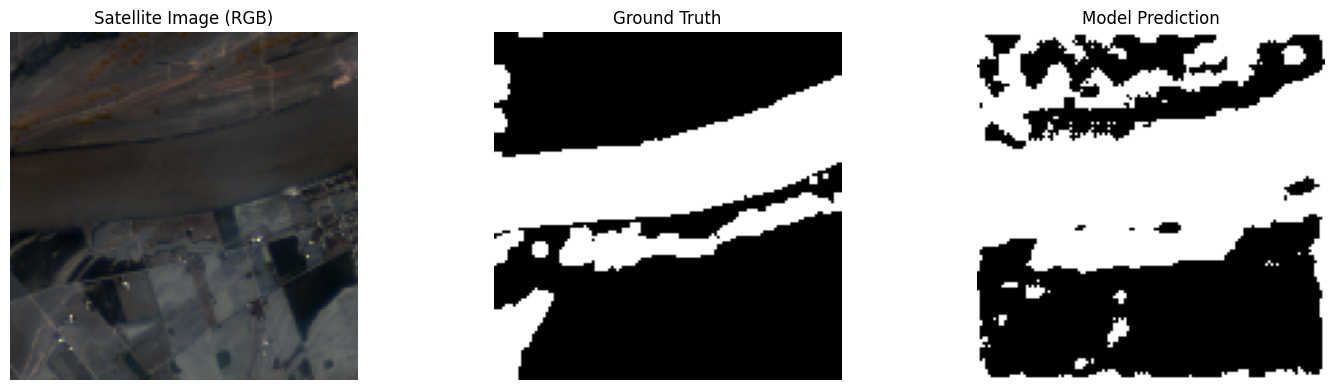

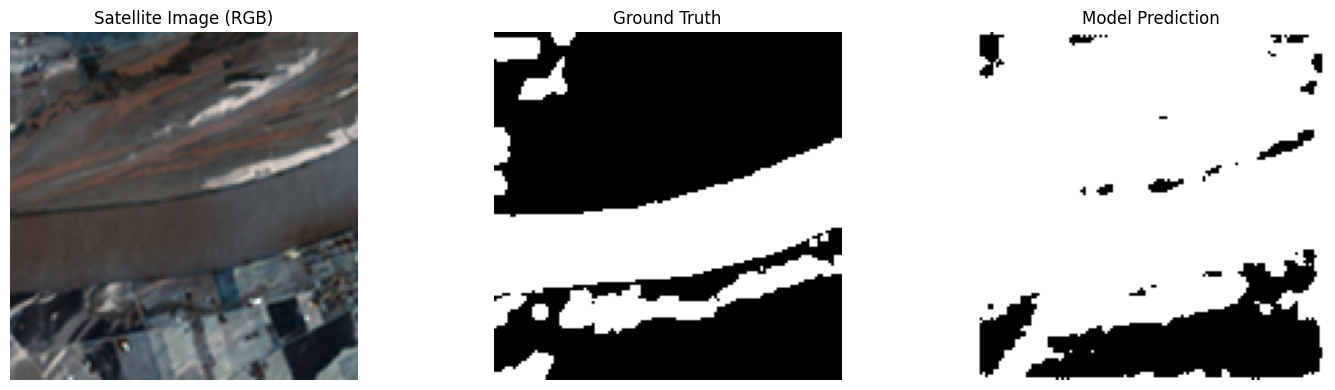

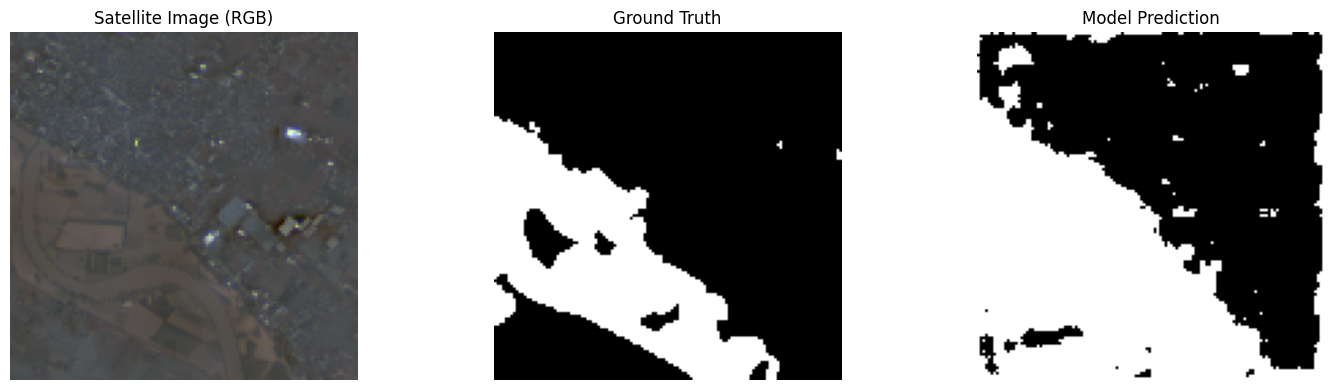

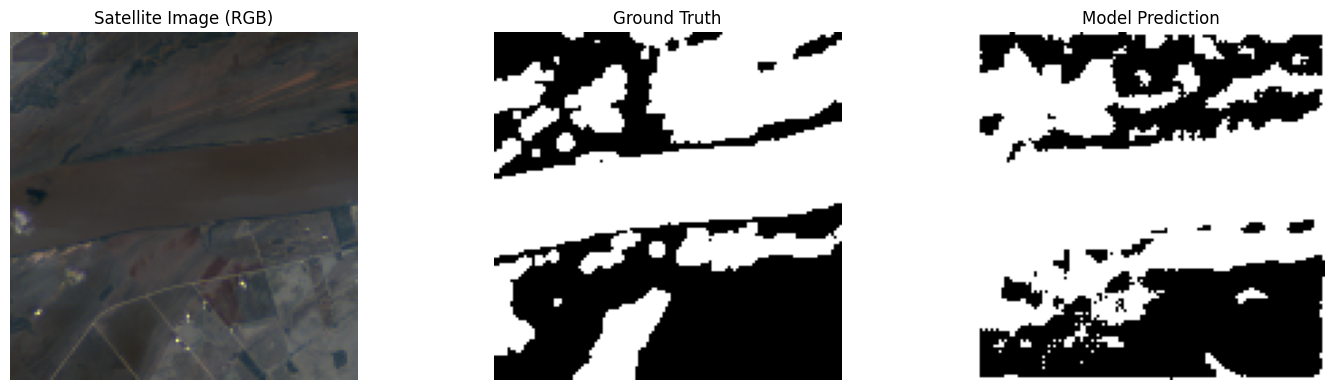

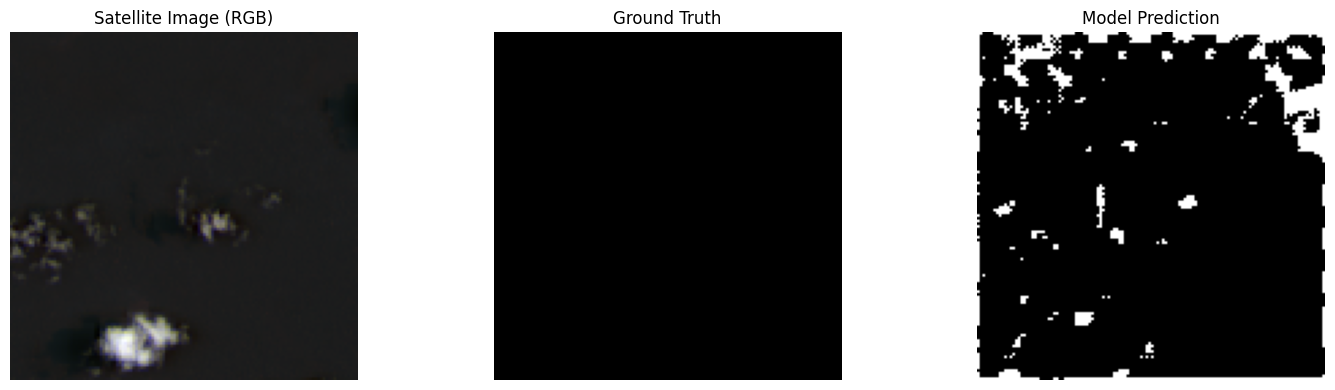

🔍 Visualizing Predictions:   0%|          | 0/2 [00:04<?, ?it/s]


In [164]:
visualize_predictions(model, test_loader, device, num_samples=5)